In [90]:
from sklearn import preprocessing, model_selection
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from numpy import genfromtxt

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [91]:
experiments = [dI for dI in os.listdir('../experiments') if os.path.isdir(os.path.join('../experiments',dI))]

best_models = []
for experiment in experiments:
    training_metrics = pd.read_csv('../experiments/' + experiment + '/training_metrics.csv')
    training_metrics = training_metrics.sort_values(['acc', 'precision', 'recall'], ascending=[False, False, False])
    best_model = training_metrics.iloc[0]
    best_model["experiment"] = experiment
    
    best_models.append(best_model)
    
best_models = pd.DataFrame(best_models).reset_index().drop(columns=['index'])
best_models

/Users/gcarvs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,model_name,units,learning_rate,momentum,decay,activation_function,acc,loss,mae,mse,precision,recall,fs_score,experiment
0,model_345,75,0.0001,0.10,0.10,relu,0.548084,0.895111,0.5,0.329349,0.547812,0.530612,0.539075,pmean_body
1,model_262,75,0.0100,0.01,0.01,relu,0.578577,0.686320,0.5,0.262988,0.579032,0.563579,0.571201,mean_body
2,model_54,150,0.0100,0.10,0.01,sigmoid,0.544959,0.692108,0.5,0.250166,0.548209,0.539295,0.543716,lstm_title


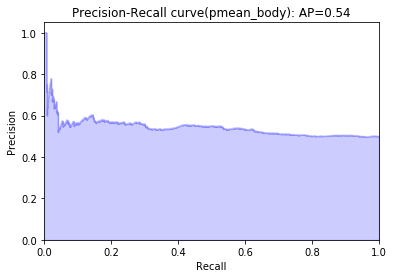

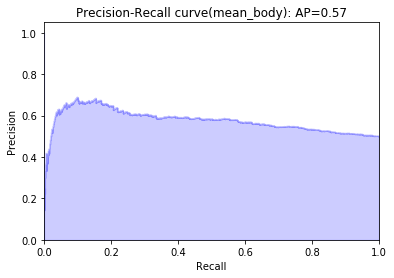

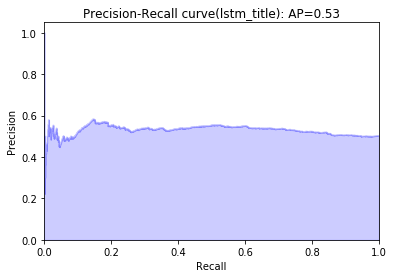

In [92]:
for index, model in best_models.iterrows(): 
    true_y = genfromtxt('../experiments/'+ model["experiment"] +'/test_y.csv', delimiter=',')
    output_probabilities = genfromtxt('../experiments/'+ model["experiment"] +'/trained_models/' + model["model_name"] + '/test_output_probabilities.csv', delimiter=',')

    probas_pred = output_probabilities[...,1]

    average_precision = average_precision_score(true_y, probas_pred)
    precision, recall, _ = precision_recall_curve(true_y, probas_pred)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve('+ model["experiment"] +'): AP={0:0.2f}'.format(
              average_precision))
    os.mkdir('../data-analysis/' + model["experiment"])
    plt.savefig('../data-analysis/'+ model["experiment"] +'/'+ model["experiment"] +'_precision_recall_curve.png', dpi=300)
    plt.show()

In [93]:


# true_y = genfromtxt('../experiments/experiment_lstm_title/test_y.csv', delimiter=',')
# output_probabilities = genfromtxt('../experiments/experiment_lstm_title/trained_models/' + best_model["model_name"] + '/test_output_probabilities.csv', delimiter=',')

# probas_pred = output_probabilities[...,1]

# average_precision = average_precision_score(true_y, probas_pred)
# precision, recall, _ = precision_recall_curve(true_y, probas_pred)

# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2,
#                  color='b')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Dollar rate classification(LSTM + news title): AP={0:0.2f}'.format(
#           average_precision))

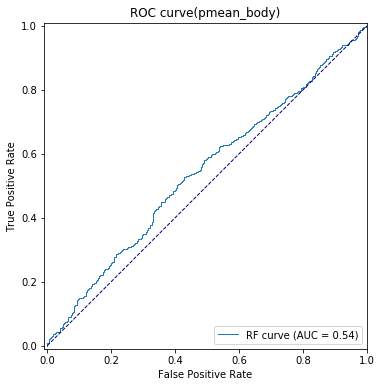

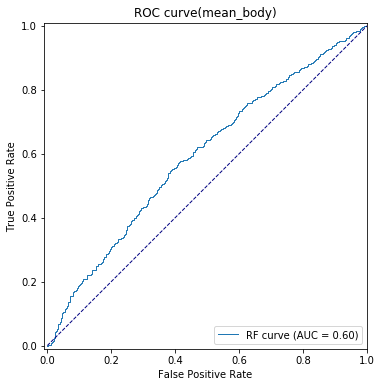

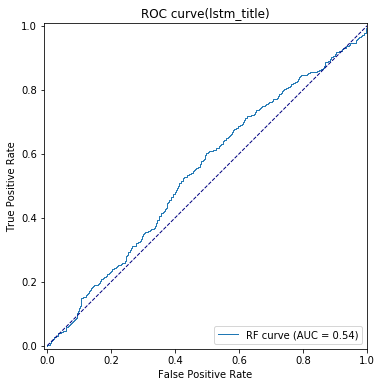

In [100]:
for index, model in best_models.iterrows(): 
    true_y = genfromtxt('../experiments/'+ model["experiment"] +'/test_y.csv', delimiter=',')
    output_probabilities = genfromtxt('../experiments/'+ model["experiment"] +'/trained_models/' + model["model_name"] + '/test_output_probabilities.csv', delimiter=',')
    
    probas_pred = output_probabilities[...,1]
    
    fpr_rf, tpr_rf, _ = roc_curve(true_y, probas_pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.figure(figsize=(6,6))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve('+ model["experiment"] +')')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    #os.mkdir('../data-analysis/' + model["experiment"])
    plt.savefig('../data-analysis/'+ model["experiment"] +'/'+ model["experiment"] +'_roc_curve.png', dpi=300)

    plt.show()

In [96]:
# train_y = genfromtxt('../experiments/experiment_lstm_title/train_y.csv', delimiter=',')
# test_y = genfromtxt('../experiments/experiment_lstm_title/test_y.csv', delimiter=',')
# predicted_y = genfromtxt('../experiments/experiment_lstm_title/trained_models/' + best_model["model_name"] + '/predicted_y.csv', delimiter=',')

# plt.hist([train_y, test_y, predicted_y], label=['Train', 'Test', 'Predicted'])
# plt.legend(loc='upper center')
# plt.title('Class distribution')